In [13]:
!pip install pandas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import constants as cs

%reload_ext autoreload
%autoreload 2


import seaborn as sns
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

In [24]:
# Parameters (to be updated with real world data)
S0_1 = 549.6          # Initial price of asset 1 LONZA
S0_2 = 240.4          # Initial price of asset 2 SIKA
T = 1.0               # Time in years
r = 0.018             # Risk-free rate
N = 252               # Number of time steps in simulation
M = 100000            # Number of simulations

# Heston parameters for asset 1 (to be calibrated)
kappa_1 = 3
theta_1 = 0.20**2
v0_1 = 0.25**2
rho_S1v1 = -0.7
sigma_1 = 0.6

# Heston parameters for asset 2 (to be calibrated)
kappa_2 = 2.5
theta_2 = 0.25**2
v0_2 = 0.30**2
rho_S2v2 = -0.6
sigma_2 = 0.5

# Correlations between assets (to be calibrated)
rho_S1S2 = 0.5       # Correlation between asset prices
rho_v1v2 = 0.3       # Correlation between variances

In [ ]:
def is_positive_definite(matrix):
    """Check if the matrix is positive definite."""
    return np.all(np.linalg.eigvals(matrix) > 0)

def simulate_two_asset_heston(S0_1, S0_2, v0_1, v0_2, params, T, N, M):
    dt = T / N
    mu = np.zeros(4)

    # Construct the covariance matrix
    cov_matrix = np.array([
        [1, params['rho_S1S2'], params['rho_S1v1'], 0],
        [params['rho_S1S2'], 1, 0, params['rho_S2v2']],
        [params['rho_S1v1'], 0, 1, params['rho_v1v2']],
        [0, params['rho_S2v2'], params['rho_v1v2'], 1]
    ])

    # Check if the covariance matrix is positive definite
    if not is_positive_definite(cov_matrix):
        raise ValueError("Covariance matrix is not positive definite. Please adjust the correlation coefficients.")

    # Cholesky decomposition
    L = np.linalg.cholesky(cov_matrix)

    # Initialize arrays
    S1 = np.full((N+1, M), S0_1)
    v1 = np.full((N+1, M), v0_1)
    S2 = np.full((N+1, M), S0_2)
    v2 = np.full((N+1, M), v0_2)

    for i in range(1, N+1):
        # Generate correlated Brownian increments
        Z = np.random.normal(size=(M, 4))
        dW = Z @ L.T * np.sqrt(dt)

        # Asset 1
        v1_prev = v1[i-1]
        v1_sqrt = np.sqrt(np.maximum(v1_prev, 0))
        v1[i] = v1_prev + params['kappa_1'] * (params['theta_1'] - v1_prev) * dt + params['sigma_1'] * v1_sqrt * dW[:, 2]
        v1[i] = np.maximum(v1[i], 0)
        S1[i] = S1[i-1] * np.exp((r - 0.5 * v1_prev) * dt + v1_sqrt * dW[:, 0])

        # Asset 2
        v2_prev = v2[i-1]
        v2_sqrt = np.sqrt(np.maximum(v2_prev, 0))
        v2[i] = v2_prev + params['kappa_2'] * (params['theta_2'] - v2_prev) * dt + params['sigma_2'] * v2_sqrt * dW[:, 3]
        v2[i] = np.maximum(v2[i], 0)
        S2[i] = S2[i-1] * np.exp((r - 0.5 * v2_prev) * dt + v2_sqrt * dW[:, 1])

    return S1, v1, S2, v2

# Heston parameters and adjusted correlations
params = {
    'kappa_1': 3,
    'theta_1': 0.20**2,
    'sigma_1': 0.6,
    'rho_S1v1': -0.5,
    'kappa_2': 2.5,
    'theta_2': 0.25**2,
    'sigma_2': 0.5,
    'rho_S2v2': -0.5,
    'rho_S1S2': 0.5,
    'rho_v1v2': 0.2
}

# Simulate the assets
S1, v1, S2, v2 = simulate_two_asset_heston(S0_1, S0_2, params['theta_1'], params['theta_2'], params, T, N, M)


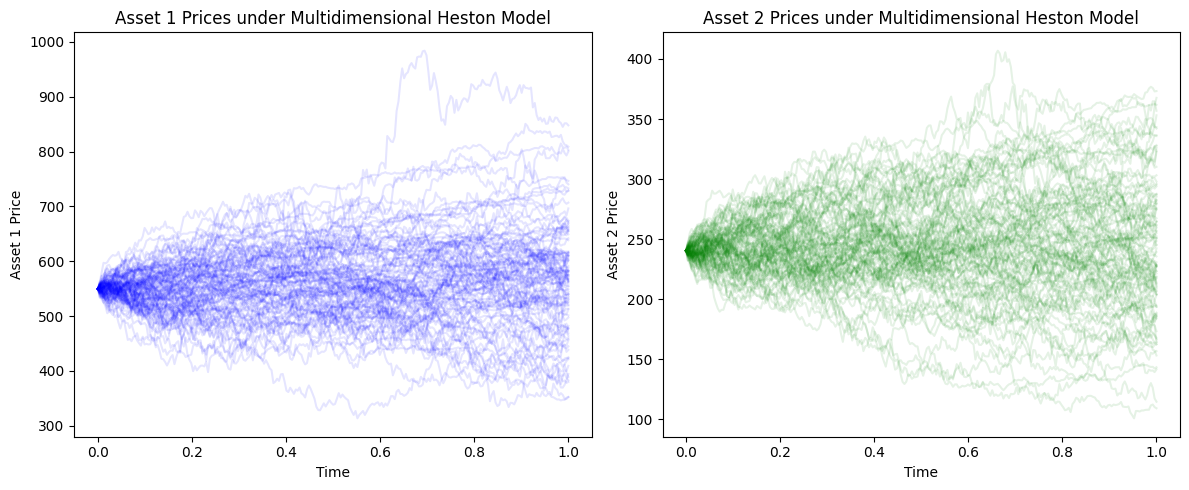

In [34]:
# Plotting the asset prices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0, T, N+1)

# Plot sample paths (only plotting the first 100 paths to reduce clutter)
ax1.plot(time, S1[:, :100], color='blue', alpha=0.1)
ax1.set_title('LONZA Prices under Multidimensional Heston Model')
ax1.set_xlabel('Time')
ax1.set_ylabel('LONZA Price')

ax2.plot(time, S2[:, :100], color='green', alpha=0.1)
ax2.set_title('SIKA Prices under Multidimensional Heston Model')
ax2.set_xlabel('Time')
ax2.set_ylabel('SIKA Price')

plt.tight_layout()
plt.show()

# Calculate joint payoffs or options as needed


In [22]:
#our payoff function
def calculate_payoff(pathS1, pathS2, terminalS1, terminalS2, initinvestment, initpriceS1 =  549.60, initpriceS2 = 240.40,  barrierS1 = 329.76, barrierS2= 144.24, conversionratioS1 = 1.8195, conversionratioS2 = 4.1597):
    '''
    initpriceS1 := Initial price of stock S1 defined to be LONZA GROUP AG (Float)
    initpriceS2 := Initial price of stock S2 defined to be SIKA AG  (Float)
    pathS1 := Stock price path of S1 (list)
    pathS2 := Stock price path of S2 (list)
    terminalS1 := Terminal price of stock S1 on the final fixing date (Float)
    terminalS2 := Terminal price of stock S2 on the final fixing date (Float)
    barrierS1  := Given barrier price of S1 (Float)
    barrierS2 := Given barrier price of S2 (Float)
    '''
    condA = (terminalS1 >= initpriceS1).all() and (terminalS2 >= initpriceS2).all() # condition where terminal price of S1 and S2 are above their initial level on the initial fixing date
    condB = (min(pathS1) >= barrierS1).all() and (min(pathS2) >= barrierS2).all() # condition where none of the barriers have been reached
    if condA or condB:
        payoff = (1 + (0.08/12 * 15)) * initinvestment + initinvestment
    elif not condA and not condB:
        receiving = min(terminalS1, terminalS2)
        if receiving == terminalS1:
            conversionratio = conversionratioS1
            price = terminalS1
        else:
            conversionratio = conversionratioS2
            price = terminalS2
        payoff = (1 + (0.08/12 * 15)) * initinvestment + initinvestment*conversionratio
    elif terminalS1 == 0 or terminalS2 == 0 :
        payoff = (1 + (0.08/12 * 15)) * initinvestment

    return payoff

def checkbarrier():
    """
    Takes in 1 simulated path of 2 assets and check if any of the barriers have been reached


    Returns:
        True if at least one of the barriers has been breached throught the lifetime of this simulaation
    """
    pass


def check_terminal():
    """
    Takes in 1 simulated path of 2 assets and check if the terminal price < initial price on initial fixing date

    Returns:
        True if one of the assets has terminal price lower then the initial price

    """
    pass

def payoff(sim , checkbarrier):
    """
    Takes in 1 simulated path of 2 assets and check if any of the barriers have been reached

    Returns:

    """
    pass
def discounting_to_present_1(sims: pd.DataFrame):

    """
    Takes in a dataframe of simulated results from stock price
    1. checks for barriers if they have been reached
    2. checks for early redemption
    """
    pass

params_product = {
    'initinvestment': 1000,
    'barrierS1': 0.6 * S0_1,     # 60% barrier for asset 1
    'barrierS2': 0.6 * S0_2,     # 60% barrier for asset 2
    'initial_S1': S0_1,
    'initial_S2': S0_2,
    'conversionratioS1': 1.8195,
    'conversionratioS2': 4.1597,
}

# Compute the payoffs
payoffs = calculate_payoff(S1, S2, S1[-1], S2[-1], params_product)

# Calculate expected payoff and present value
expected_payoff = np.mean(payoffs)
present_value = expected_payoff * np.exp(-r * T)

# Output the present value
print(f"The present value of the product is: {present_value:.2f}")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [35]:
#payoff function generated by ChatGPT-4o1 preview, just for testing purpose
def compute_payoff(S_LONZA_paths, S_SIKA_paths, params):
    """
    Computes the payoff for each simulation.

    Inputs:
    - S_LONZA_paths: Simulated paths for LONZA (numpy array of shape [N+1, M])
    - S_SIKA_paths: Simulated paths for SIKA (numpy array of shape [N+1, M])
    - params: Dictionary containing product parameters

    Outputs:
    - payoffs: Numpy array of payoffs for each simulation (shape [M])
    """
    M = S_LONZA_paths.shape[1]
    N = S_LONZA_paths.shape[0] - 1  # Number of time steps
    payoffs = np.zeros(M)

    dt = params['T'] / N
    time_grid = np.linspace(0, params['T'], N+1)

    # Determine early observation dates (e.g., quarterly after 6 months)
    early_observation_times = params['early_observation_times']
    early_indices = [np.searchsorted(time_grid, t) for t in early_observation_times]

    for i in range(M):
        early_redeemed = False
        S_LONZA = S_LONZA_paths[:, i]
        S_SIKA = S_SIKA_paths[:, i]

        # Check for early redemption
        for idx, t_idx in enumerate(early_indices):
            if (S_LONZA[t_idx] >= params['Early_Redemption_Level_LONZA'] and
                S_SIKA[t_idx] >= params['Early_Redemption_Level_SIKA']):
                # Early redemption occurs
                periods = idx + 1
                payoffs[i] = params['Denomination'] * (1 + params['Coupon_Rate'] * periods)
                early_redeemed = True
                break  # Exit early as the product is redeemed

        if not early_redeemed:
            # Check for barrier breach
            barrier_breached = np.any((S_LONZA <= params['Barrier_LONZA']) | (S_SIKA <= params['Barrier_SIKA']))

            # Final prices at maturity
            final_S_LONZA = S_LONZA[-1]
            final_S_SIKA = S_SIKA[-1]

            periods = len(early_observation_times)  # Total periods if held to maturity

            if not barrier_breached and (final_S_LONZA >= params['S0_LONZA'] and final_S_SIKA >= params['S0_SIKA']):
                # Full redemption with coupons
                payoffs[i] = params['Denomination'] * (1 + params['Coupon_Rate'] * periods)
            else:
                # Payoff based on worst-performing asset
                performance_LONZA = final_S_LONZA / params['S0_LONZA']
                performance_SIKA = final_S_SIKA / params['S0_SIKA']

                worst_performance = min(performance_LONZA, performance_SIKA)
                payoffs[i] = params['Denomination'] * worst_performance
                # Include coupons
                payoffs[i] += params['Denomination'] * params['Coupon_Rate'] * periods

    return payoffs

# Product parameters
params_product = {
    'Denomination': 1000,
    'Coupon_Rate': 0.08 / 4,  # Quarterly coupon payments
    'Barrier_LONZA': 0.6 * S0_1,  # 60% barrier for LONZA
    'Barrier_SIKA': 0.6 * S0_2,    # 60% barrier for SIKA
    'Early_Redemption_Level_LONZA': S0_1,
    'Early_Redemption_Level_SIKA': S0_2,
    'S0_LONZA': S0_1,
    'S0_SIKA': S0_2,
    'T': T,
    'early_observation_times': [0.5, 0.75, 1.0],  # Observation times in years
}

# Compute the payoffs
payoffs = compute_payoff(S1, S2, params_product)
expected_payoff = np.mean(payoffs)
present_value = expected_payoff * np.exp(-r * T)

# Output the present value
print(f"The present value of the product is: {present_value:.2f}")


The present value of the product is: 918.98
